C:\Users\Mohib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Weighted Hybrid Model - RMSE: 0.4682
Weighted Hybrid Model - MAE: 0.3781
Weighted Hybrid Model - R² Score: -0.0069


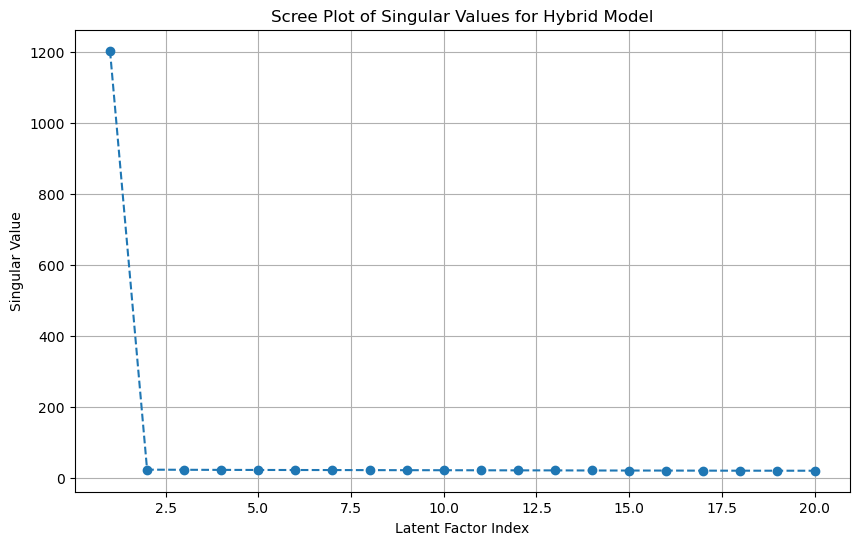

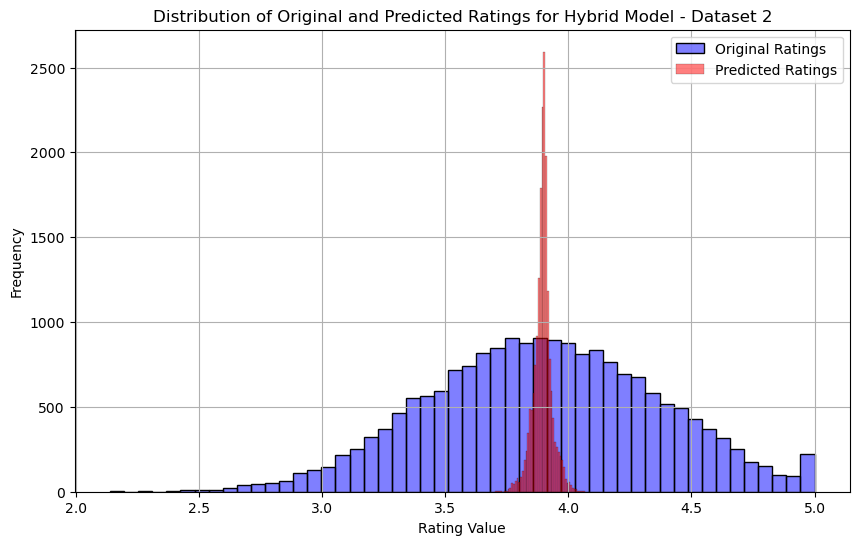

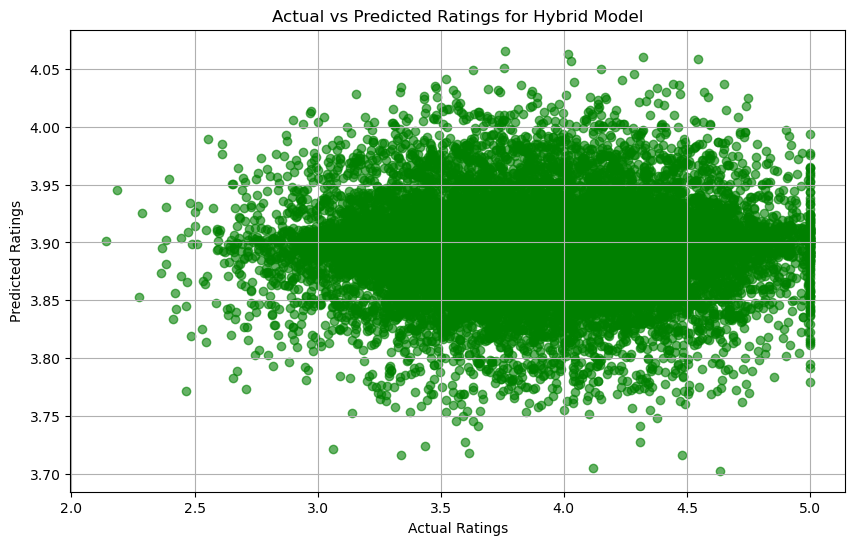

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('final_accomodations_data.csv')
user_ratings_df = pd.read_csv('user_ratings_accommodations.csv')

df = df.merge(user_ratings_df, left_on='accommodation_id', right_on='Accommodation_ID', how='inner')

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

df['Account Name'] = df['Account Name'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  
account_name_matrix = vectorizer.fit_transform(df['Account Name'])

scaler = MinMaxScaler()
df[['Rating', 'Latitude', 'Longitude']] = scaler.fit_transform(df[['Rating', 'Latitude', 'Longitude']])

content_matrix = hstack([account_name_matrix, csr_matrix(df[['Rating', 'Latitude', 'Longitude']].values)])

n_components = 20  
content_svd = TruncatedSVD(n_components=n_components, random_state=42)
content_matrix_reduced = content_svd.fit_transform(content_matrix)

user_item_matrix = user_ratings_df.pivot(index='User_ID', columns='Accommodation_ID', values='User_Rating').fillna(0)
user_item_matrix = csr_matrix(user_item_matrix.values)

svd = TruncatedSVD(n_components=n_components, random_state=42)
user_item_reduced = svd.fit_transform(user_item_matrix)

user_item_approx_reduced_expanded = np.tile(user_item_reduced, (int(np.ceil(content_matrix.shape[0] / user_item_reduced.shape[0])), 1))
user_item_approx_reduced_expanded = user_item_approx_reduced_expanded[:content_matrix.shape[0], :]

user_item_approx_reduced_expanded_sparse = csr_matrix(user_item_approx_reduced_expanded)

kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(account_name_matrix)

cluster_features = pd.get_dummies(df['Cluster'])
cluster_matrix = csr_matrix(cluster_features.values)

weight_content = 0.6
weight_collaborative = 0.3
weight_cluster = 0.1

hybrid_matrix = hstack([
    weight_content * content_matrix, 
    weight_collaborative * user_item_approx_reduced_expanded_sparse, 
    weight_cluster * cluster_matrix
])

y = df['User_Rating'].values

X_train, X_test, y_train, y_test = train_test_split(hybrid_matrix, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train.toarray(), y_train)

y_pred = ridge_model.predict(X_test.toarray())

rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred))
mae_hybrid = mean_absolute_error(y_test, y_pred)
r2_hybrid = r2_score(y_test, y_pred)

print(f"Weighted Hybrid Model - RMSE: {rmse_hybrid:.4f}")
print(f"Weighted Hybrid Model - MAE: {mae_hybrid:.4f}")
print(f"Weighted Hybrid Model - R² Score: {r2_hybrid:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), svd.singular_values_, marker='o', linestyle='--')
plt.xlabel('Latent Factor Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values for Hybrid Model')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color='blue', alpha=0.5, label='Original Ratings')
sns.histplot(y_pred, bins=50, color='red', alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Predicted Ratings for Hybrid Model - Dataset 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings for Hybrid Model')
plt.grid(True)
plt.show()


In [13]:
def generate_recommendations(user_id, ridge_model, hybrid_matrix, df, top_n=5):
    
    df = df.drop_duplicates(subset=['accommodation_id'], keep='first')

    user_index = user_id - 1 
    user_features = hybrid_matrix[user_index].toarray()

    repeated_user_features = np.tile(user_features, (df.shape[0], 1))


    recommendations = pd.DataFrame({
        'Accommodation': df['Account Name'].values,
    })


    return recommendations.head(top_n)


In [14]:
# Generate recommendations for user ID 1
user_id = 1
top_n = 5

try:
    top_recommendations = generate_recommendations(user_id, ridge_model, hybrid_matrix, df, top_n)

    # Display the recommendations
    print(f"Top {top_n} recommendations for User {user_id} - Dataset 2:")
    print(top_recommendations)
except ValueError as e:
    print(f"Error: {e}")


Top 5 recommendations for User 1 - Dataset 2:
                     Accommodation
0  Druids Glen Hotel & Golf Resort
1                   Glenview Hotel
2                The Western Hotel
3                     Hotel Isaacs
4      Maldron Hotel Pearse Street


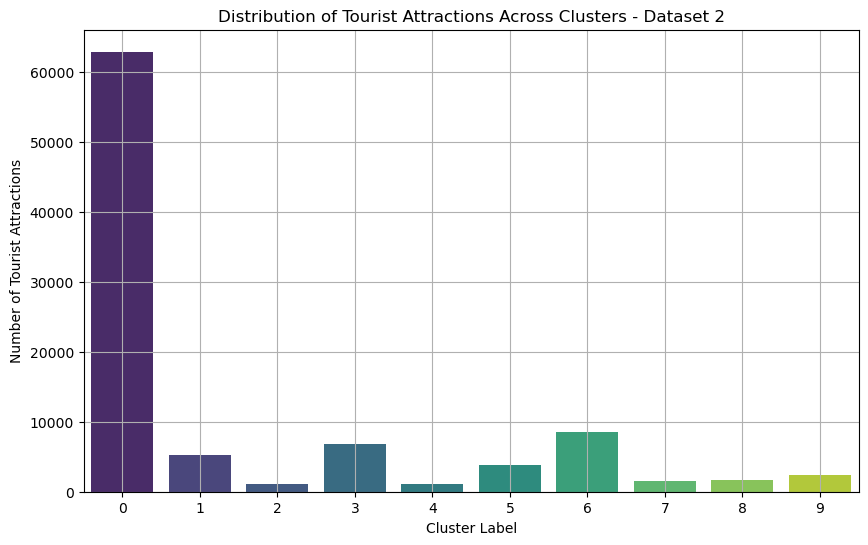

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, palette='viridis')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Tourist Attractions')
plt.title('Distribution of Tourist Attractions Across Clusters - Dataset 2')
plt.grid(True)
plt.show()